Test samples: 254
Label distribution:
1    129
0    125
Name: count, dtype: int64


2025-12-26 08:06:35.577161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766736395.764645      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766736395.817162      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766736396.262310      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766736396.262357      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766736396.262360      24 computation_placer.cc:177] computation placer alr


===== ENSEMBLE TEST METRICS =====
Accuracy          : 0.8701
F1 (macro)        : 0.8690
F1 (weighted)     : 0.8688
Precision (macro) : 0.8866
Recall (macro)    : 0.8717

Classification Report:
              precision    recall  f1-score   support

           0     0.8026    0.9760    0.8809       125
           1     0.9706    0.7674    0.8571       129

    accuracy                         0.8701       254
   macro avg     0.8866    0.8717    0.8690       254
weighted avg     0.8879    0.8701    0.8688       254



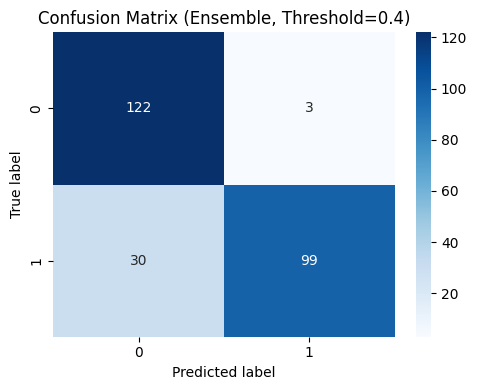

In [1]:
# =========================
# IMPORT
# =========================
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# =========================
# CONFIG
# =========================
PHOBERT_DIR = "/kaggle/input/phobert-ckpt2"
XLMR_DIR = "/kaggle/input/xlmr-ckpt/final_model"

TEST_FILE = "/kaggle/input/test-data2/test_data1.csv"
TEXT_COL = "text"
LABEL_COL = "label"

BATCH_SIZE = 16
MAX_LEN = 256
THRESHOLD = 0.40  # Có thể điều chỉnh threshold

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD TEST DATA
# =========================
df_test = pd.read_csv(TEST_FILE)
texts = df_test[TEXT_COL].astype(str).tolist()
labels = df_test[LABEL_COL].astype(int).to_numpy()

print(f"Test samples: {len(texts)}")
print("Label distribution:")
print(pd.Series(labels).value_counts())

# =========================
# LOAD TOKENIZERS & MODELS
# =========================
tokenizer_phobert = AutoTokenizer.from_pretrained(PHOBERT_DIR, local_files_only=True)
model_phobert = AutoModelForSequenceClassification.from_pretrained(PHOBERT_DIR, local_files_only=True)
model_phobert.to(DEVICE)
model_phobert.eval()

tokenizer_xlmr = AutoTokenizer.from_pretrained(XLMR_DIR, local_files_only=True)
model_xlmr = AutoModelForSequenceClassification.from_pretrained(XLMR_DIR, local_files_only=True)
model_xlmr.to(DEVICE)
model_xlmr.eval()

# =========================
# FUNCTION: PREDICTION BATCHED
# =========================
def get_probs(model, tokenizer, texts, batch_size=16, max_len=256):
    probs_all = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            enc = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = enc["input_ids"].to(DEVICE)
            attention_mask = enc["attention_mask"].to(DEVICE)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=-1)  # shape [batch, 2]
            probs_all.append(probs.cpu().numpy())
    return np.vstack(probs_all)

# =========================
# GET PROBABILITIES FROM BOTH MODELS
# =========================
probs_phobert = get_probs(model_phobert, tokenizer_phobert, texts, BATCH_SIZE, MAX_LEN)
probs_xlmr = get_probs(model_xlmr, tokenizer_xlmr, texts, BATCH_SIZE, MAX_LEN)

# =========================
# SOFT VOTING ENSEMBLE
# =========================
probs_ensemble = (probs_phobert + probs_xlmr) / 2
preds_ensemble = (probs_ensemble[:, 1] >= THRESHOLD).astype(int)

# =========================
# METRICS
# =========================
acc = accuracy_score(labels, preds_ensemble)
f1_macro = f1_score(labels, preds_ensemble, average="macro")
f1_weighted = f1_score(labels, preds_ensemble, average="weighted")
precision_macro = precision_score(labels, preds_ensemble, average="macro")
recall_macro = recall_score(labels, preds_ensemble, average="macro")

print("\n===== ENSEMBLE TEST METRICS =====")
print(f"Accuracy          : {acc:.4f}")
print(f"F1 (macro)        : {f1_macro:.4f}")
print(f"F1 (weighted)     : {f1_weighted:.4f}")
print(f"Precision (macro) : {precision_macro:.4f}")
print(f"Recall (macro)    : {recall_macro:.4f}")

print("\nClassification Report:")
print(classification_report(labels, preds_ensemble, digits=4))

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(labels, preds_ensemble)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[0,1],
    yticklabels=[0,1]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (Ensemble, Threshold={THRESHOLD})")
plt.tight_layout()
plt.show()
